In [2]:
import statsmodels as ss
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
# Read in dataset
yearly_gdp = pd.read_csv('malaysian_gdp.csv', header=0, names=['date','gdp'], sep=',', index_col='date')
yearly_gdp.index = pd.to_datetime(yearly_gdp.index)
yearly_gdp.head()

,gdp
date,
1960-01-01,1.916229e+09
1961-01-01,1.901856e+09
1962-01-01,2.001490e+09
1963-01-01,2.510110e+09
1964-01-01,2.674424e+09


In [4]:
yearly_gdp.describe()

,gdp
count,6.400000e+01
mean,1.143234e+11
std,1.298248e+11
min,1.901856e+09
25%,1.066173e+10
50%,5.415535e+10
75%,1.957265e+11
max,4.070275e+11


In [5]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=1);

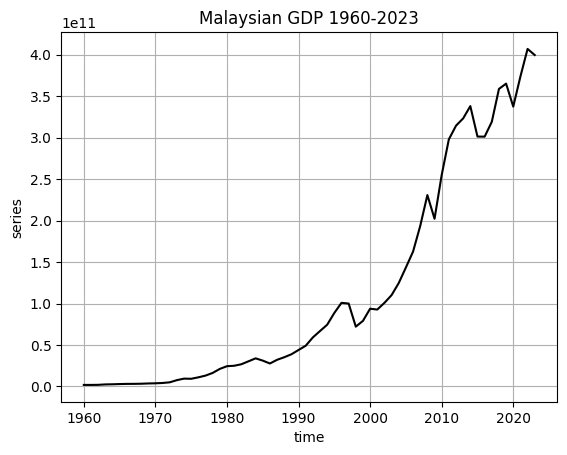

In [6]:
run_sequence_plot(yearly_gdp.index, yearly_gdp.gdp, "Malaysian GDP 1960-2023")

In [7]:
yearly_gdp['gdp_diff'] = yearly_gdp.gdp.diff().fillna(0)
yearly_gdp['gdp_log'] = np.log(yearly_gdp.gdp)
yearly_gdp['gdp_log_diff'] = yearly_gdp.gdp_log.diff().fillna(0)

In [8]:
yearly_gdp.describe()

,gdp,gdp_diff,gdp_log,gdp_log_diff
count,6.400000e+01,6.400000e+01,64.000000,64.000000
mean,1.143234e+11,6.214572e+09,24.455444,0.083441
std,1.298248e+11,1.558829e+10,1.709471,0.109299
min,1.901856e+09,-3.671083e+10,21.366096,-0.326234
25%,1.066173e+10,1.585969e+08,23.087828,0.025992
50%,5.415535e+10,3.246775e+09,24.710821,0.094741
75%,1.957265e+11,1.055581e+10,25.999801,0.144854
max,4.070275e+11,5.276019e+10,26.732146,0.418321


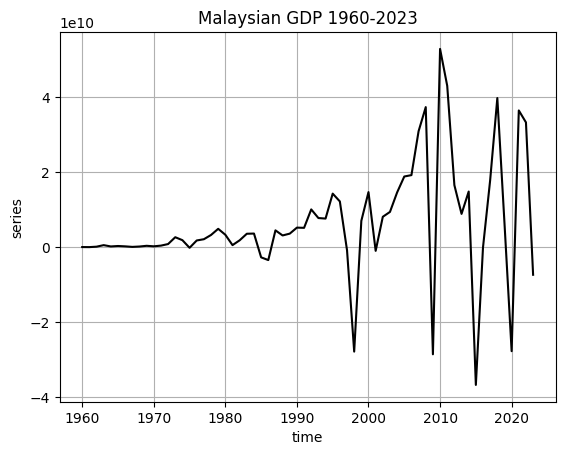

In [9]:
run_sequence_plot(yearly_gdp.index, yearly_gdp.gdp_diff, "Malaysian GDP 1960-2023")

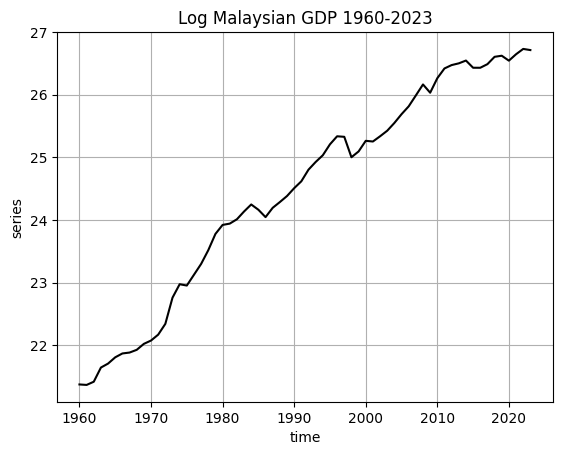

In [10]:
run_sequence_plot(yearly_gdp.index,yearly_gdp.gdp_log, "Log Malaysian GDP 1960-2023")

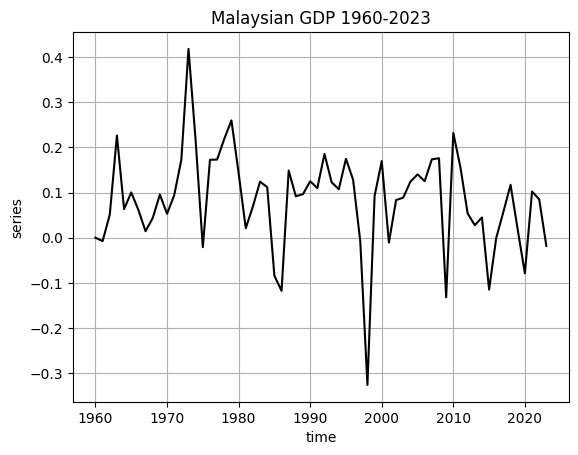

In [11]:
run_sequence_plot(yearly_gdp.index, yearly_gdp.gdp_log_diff, "Malaysian GDP 1960-2023")

In [12]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5).mean()
    rolstd = timeseries.rolling(window=5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic          -1.359012
p-value                  0.601761
Lags Used               11.000000
Observations Used       52.000000
Critical Value (1%)     -3.562879
Critical Value (5%)     -2.918973
Critical Value (10%)    -2.597393
dtype: float64


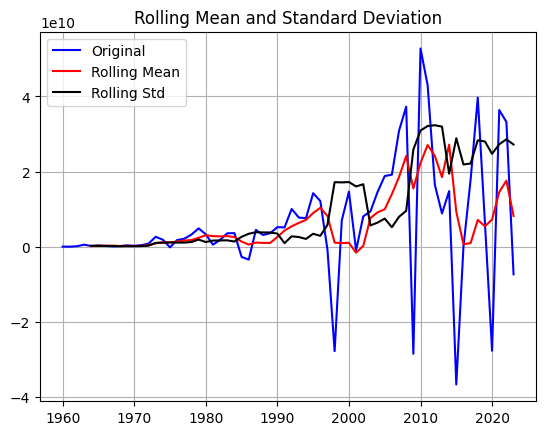

In [13]:
dftest(yearly_gdp.gdp_diff.dropna())

Test Statistic          -2.132626
p-value                  0.231599
Lags Used                2.000000
Observations Used       61.000000
Critical Value (1%)     -3.542413
Critical Value (5%)     -2.910236
Critical Value (10%)    -2.592745
dtype: float64


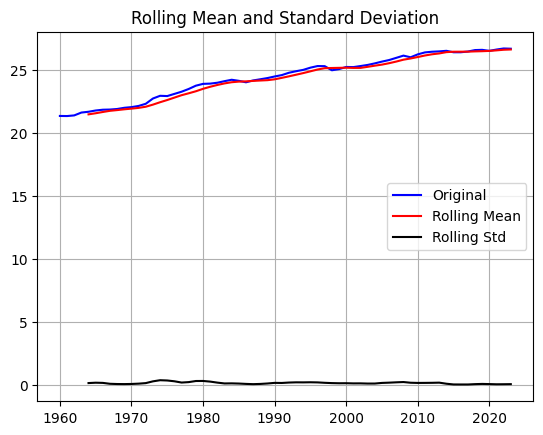

In [14]:
dftest(yearly_gdp.gdp_log)

Test Statistic         -6.150232e+00
p-value                 7.593573e-08
Lags Used               0.000000e+00
Observations Used       6.300000e+01
Critical Value (1%)    -3.538695e+00
Critical Value (5%)    -2.908645e+00
Critical Value (10%)   -2.591897e+00
dtype: float64


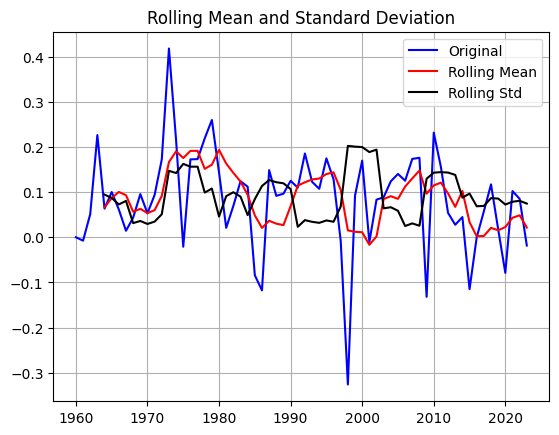

In [15]:
dftest(yearly_gdp.gdp_log_diff.dropna())

In [16]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

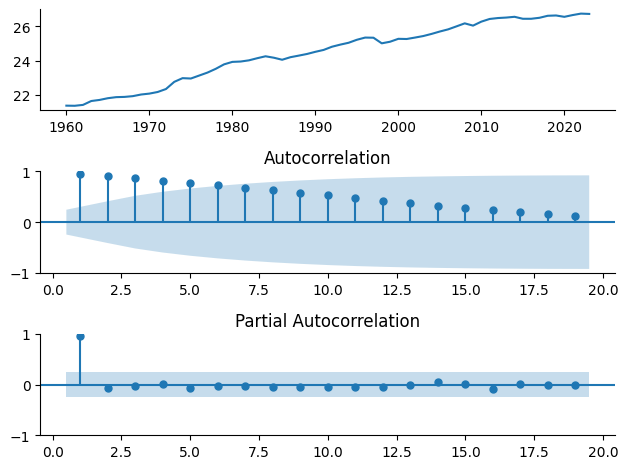

In [17]:
plots(yearly_gdp.gdp_log)

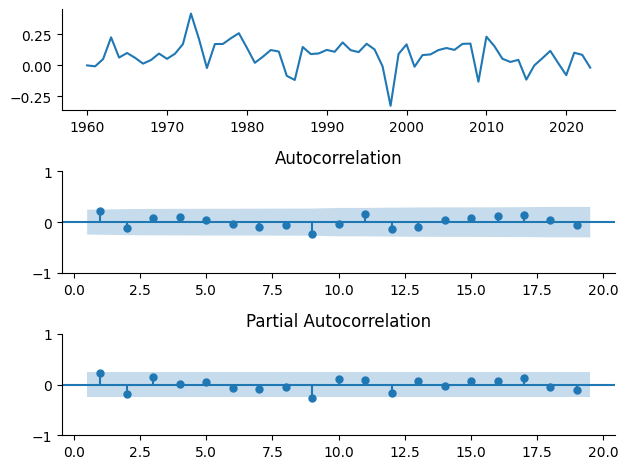

In [18]:
plots(yearly_gdp.gdp_log_diff.dropna())

In [19]:
stepwise_model = pm.auto_arima(yearly_gdp.gdp_log_diff.dropna(), start_p=1, start_q=1,
                           max_p=3, max_q=3, m=10,
                           start_P=0, seasonal=True,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[10] intercept   : AIC=-99.443, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AIC=-98.733, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AIC=-98.259, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AIC=-100.281, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AIC=-70.971, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[10] intercept   : AIC=-102.138, Time=0.69 sec
 ARIMA(0,0,1)(1,0,0)[10] intercept   : AIC=-100.246, Time=1.57 sec
 ARIMA(0,0,1)(1,0,1)[10] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(1,0,1)(0,0,0)[10] intercept   : AIC=-101.238, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[10] intercept   : AIC=-101.371, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[10] intercept   : AIC=-100.215, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[10] intercept   : AIC=-99.387, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[10]             : AIC=-87.239, Time=0.14 sec

Best model:  ARIMA(0,0,1)(0,0,0)[10] intercept
Total fit time: 7.985 seconds
-102.13795614951798

In [68]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_years):
    pred_first = series.index.max()+relativedelta(years=1)
    pred_last = series.index.max()+relativedelta(years=num_years)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'YS')
    vals = model.predict(n_periods = num_years)
    return pd.DataFrame(vals,index = date_range_index)

In [28]:
# Function to undo the log and diff transformations
def undo_transforms(X, X_0, log=False, diff=False):
    if diff:
         X = np.r_[X_0, np.squeeze(X)].cumsum()[1:]
    if log:
        X = np.exp(X)
    return X

In [49]:
# Sanity check to ensure conversion works
diff_undoing_log = sum(yearly_gdp.gdp - np.exp(yearly_gdp.gdp_log))
assert(sum(yearly_gdp.gdp - undo_transforms(yearly_gdp.gdp_log, yearly_gdp.gdp_log.iloc[0], log=True, diff=False)) == diff_undoing_log)
assert(sum(yearly_gdp.gdp - undo_transforms(yearly_gdp.gdp_diff, yearly_gdp.gdp.iloc[0], log=False, diff=True)) == 0)
sum(yearly_gdp.gdp - undo_transforms(yearly_gdp.gdp_log_diff, yearly_gdp.gdp_log.iloc[0], log=True, diff=True))

-0.0004901885986328125

predicted=0.045100, expected=0.083316
predicted=0.114033, expected=0.088728
predicted=0.080477, expected=0.123989
predicted=0.117085, expected=0.140267
predicted=0.107522, expected=0.125286
predicted=0.105470, expected=0.173673
predicted=0.133957, expected=0.176068
predicted=0.121858, expected=-0.132060
predicted=-0.038947, expected=0.231791
predicted=0.167622, expected=0.155599


c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.095501, expected=0.053872
predicted=0.084453, expected=0.027704
predicted=0.077785, expected=0.044734
predicted=0.084498, expected=-0.114952
predicted=0.024422, expected=-0.000329
predicted=0.081981, expected=0.057573
predicted=0.080957, expected=0.117201
predicted=0.102167, expected=0.017650
predicted=0.060484, expected=-0.078949
predicted=0.036588, expected=0.102372
predicted=0.108558, expected=0.085073
predicted=0.078139, expected=-0.018294
Test RMSE: 0.778 e11


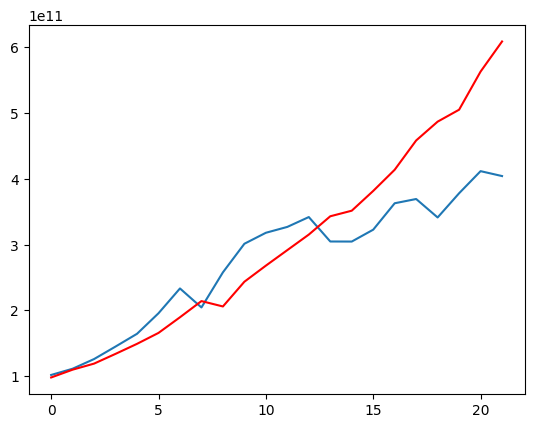

In [78]:
# split into train and test sets
X = yearly_gdp.gdp_log_diff.values[1:]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history,order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
ori_test = undo_transforms(test, yearly_gdp.gdp_log.iloc[size-1], True, True)
ori_predictions = undo_transforms(predictions, yearly_gdp.gdp_log.iloc[size-1], True, True)
rmse = sqrt(mean_squared_error(ori_test, ori_predictions))/1e11
print('Test RMSE: %.3f e11' % rmse)
# plot forecasts against actual outcomes
plt.plot(ori_test)
plt.plot(ori_predictions, color='red')
plt.show()

In [69]:
preds = future_preds_df(stepwise_model,yearly_gdp.gdp_log_diff[1:],5)
final_preds = undo_transforms(preds, yearly_gdp.gdp_log.iloc[-1], log=True, diff=True)
final_preds = pd.DataFrame(final_preds, index=preds.index)

Text(0.5, 1.0, 'MA(1) Model Forecast of Malaysian GDP 2024-2028')

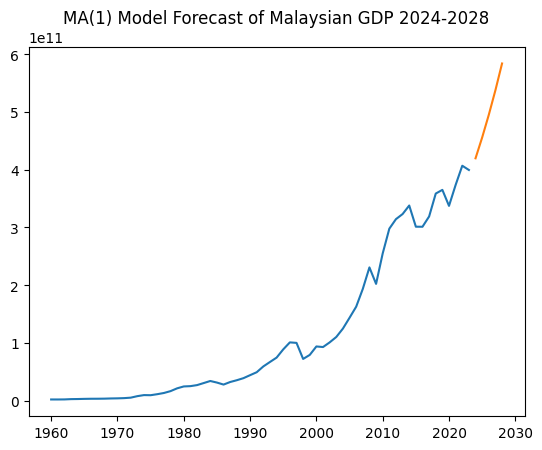

In [72]:
plt.plot(yearly_gdp.gdp)
plt.plot(final_preds)
plt.title("MA(1) Model Forecast of Malaysian GDP 2024-2028")

c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                gdp_log   No. Observations:                   64
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  45.327
Date:                Mon, 23 Sep 2024   AIC                            -86.655
Time:                        17:23:15   BIC                            -82.368
Sample:                    01-01-1960   HQIC                           -84.969
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5150      0.100      5.163      0.000       0.319       0.710
sigma2         0.0138      0.002      6.612      0.000       0.010       0.018
Ljung-Box (L1) (Q):                   1.69   Jarque-

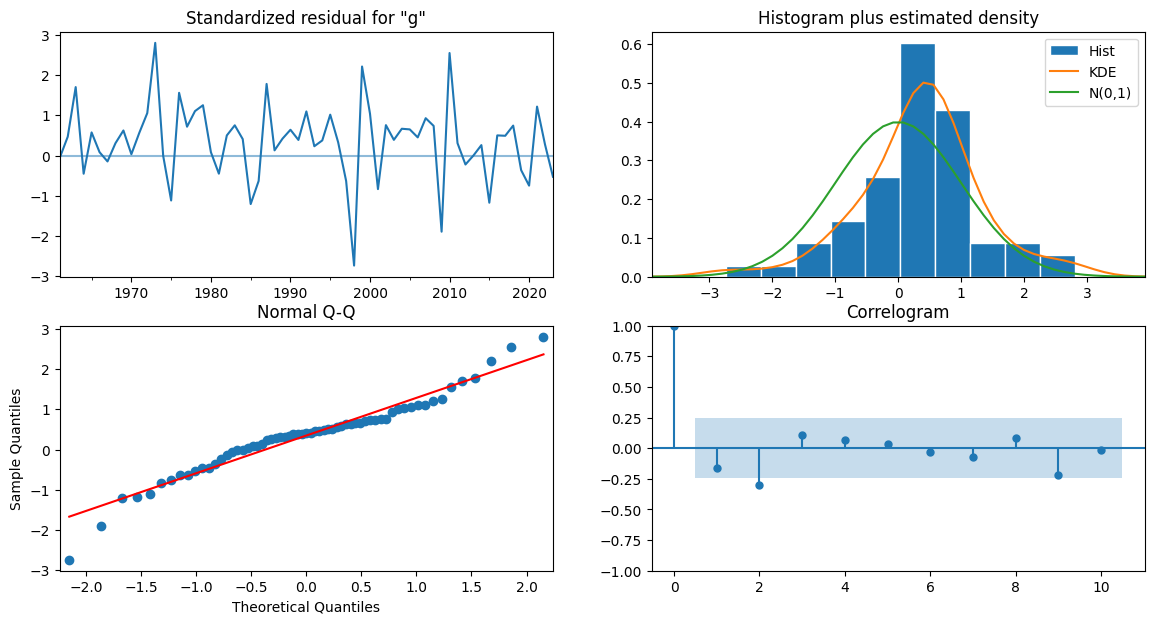

In [73]:
arima_model = ARIMA(yearly_gdp.gdp_log, order=(1,1,0)).fit()
# summary of fit model
print(arima_model.summary())
# show diagnostic plots
arima_model_diagnostics = arima_model.plot_diagnostics(figsize=(14, 7))

predicted=25.247477, expected=25.336856
predicted=25.383634, expected=25.425584
predicted=25.475747, expected=25.549573
predicted=25.620528, expected=25.689841
predicted=25.771355, expected=25.815126
predicted=25.888731, expected=25.988799
predicted=26.092967, expected=26.164868
predicted=26.272581, expected=26.032807
predicted=25.957245, expected=26.264599
predicted=26.388413, expected=26.420197
predicted=26.504336, expected=26.474069
predicted=26.502994, expected=26.501773
predicted=26.516651, expected=26.546507
predicted=26.570571, expected=26.431556
predicted=26.370331, expected=26.431226
predicted=26.431053, expected=26.488799
predicted=26.519137, expected=26.606000
predicted=26.668261, expected=26.623650
predicted=26.632952, expected=26.544701
predicted=26.503190, expected=26.647073
predicted=26.699937, expected=26.732146
predicted=26.776317, expected=26.713852
Test RMSE: 0.277 e11


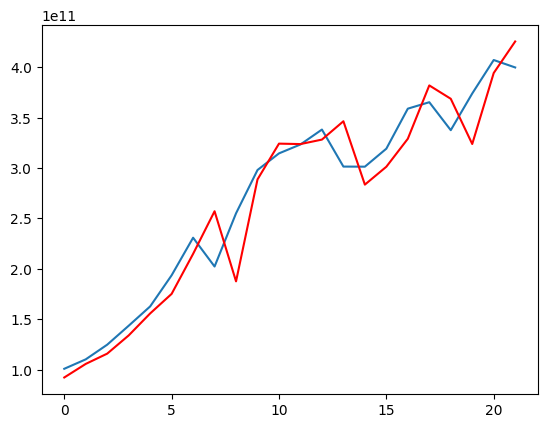

In [77]:
# split into train and test sets
X = yearly_gdp.gdp_log.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
ori_test = undo_transforms(test, yearly_gdp.gdp_log.iloc[size-1], True, False)
ori_predictions = undo_transforms(predictions, yearly_gdp.gdp_log.iloc[size-1], True, False)
rmse = sqrt(mean_squared_error(ori_test, ori_predictions))/1e11
print('Test RMSE: %.3f e11' % rmse)
# plot forecasts against actual outcomes
plt.plot(ori_test)
plt.plot(ori_predictions, color='red')
plt.show()

Text(0.5, 1.0, 'ARIMA(1,1,0) Model Forecasting Malaysian GDP 2023-2028')

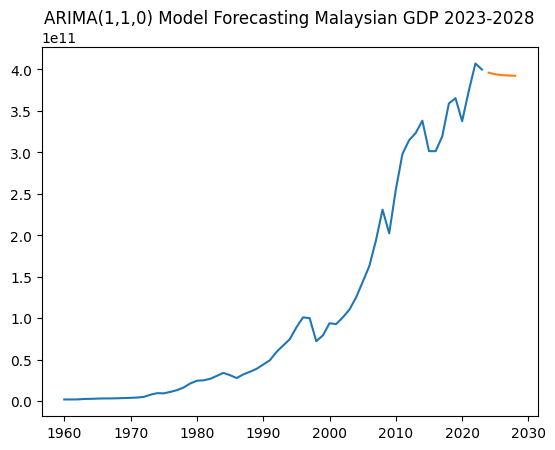

In [79]:
plt.plot(yearly_gdp.gdp)
plt.plot(np.exp(arima_model.forecast(steps=5)))
plt.title("ARIMA(1,1,0) Model Forecasting Malaysian GDP 2023-2028")

c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                             gdp_log   No. Observations:                   64
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 9)   Log Likelihood                  33.988
Date:                             Mon, 23 Sep 2024   AIC                            -59.975
Time:                                     17:25:43   BIC                            -51.946
Sample:                                 01-01-1960   HQIC                           -56.870
                                      - 01-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0195      0.069      0.282      0.778      -0.116       0.155
ar.L1          0.9747      

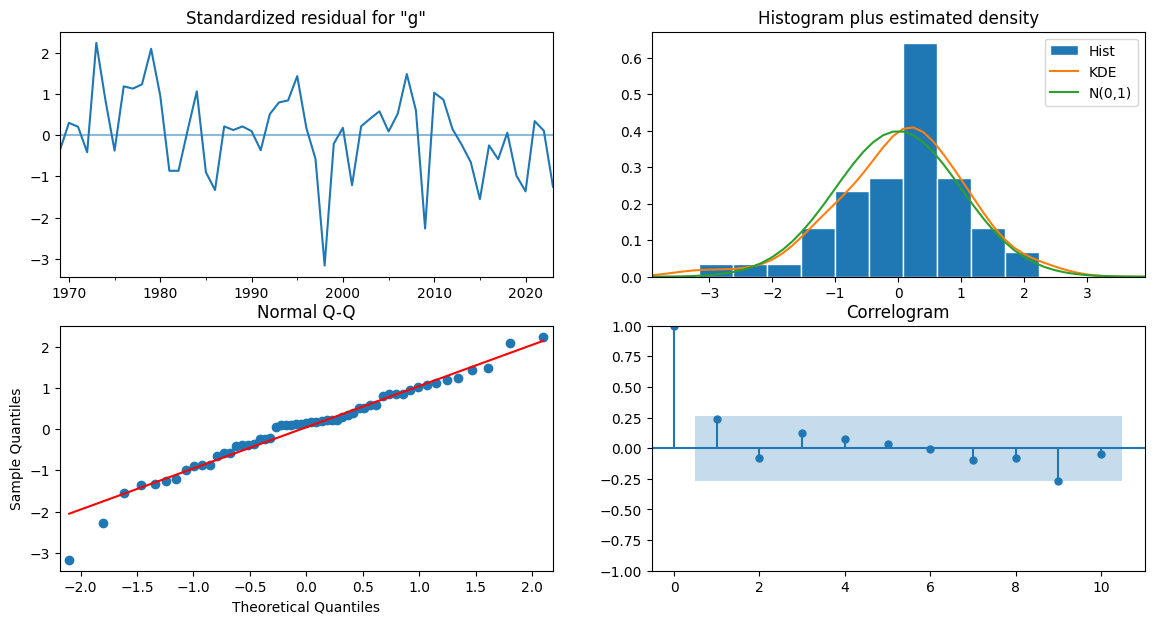

In [80]:
sarima_model = SARIMAX( yearly_gdp.gdp_log,
                        order=(1,0,0), 
                        seasonal_order=(0,1,1,9), 
                        trend='c').fit()
# summary of fit model
print(sarima_model.summary())
# Diagnostic plots
sarima_model_diagnostics = sarima_model.plot_diagnostics(figsize=(14, 7))

c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


predicted=25.337330, expected=25.336856
predicted=25.417057, expected=25.425584
predicted=25.507056, expected=25.549573
predicted=25.709656, expected=25.689841
predicted=25.779189, expected=25.815126
predicted=25.840995, expected=25.988799
predicted=26.121888, expected=26.164868
predicted=26.334423, expected=26.032807
predicted=26.170936, expected=26.264599
predicted=26.347812, expected=26.420197
predicted=26.487028, expected=26.474069
predicted=26.559777, expected=26.501773
predicted=26.656640, expected=26.546507
predicted=26.646053, expected=26.431556
predicted=26.488276, expected=26.431226
predicted=26.583466, expected=26.488799
predicted=26.620064, expected=26.606000
predicted=26.760428, expected=26.623650
predicted=26.720886, expected=26.544701
predicted=26.611482, expected=26.647073
predicted=26.726040, expected=26.732146
predicted=26.869977, expected=26.713852
Test RMSE: 0.352 e11


C:\Users\priscilla.mukuda\AppData\Local\Temp\ipykernel_6328\1089532570.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ori_test = undo_transforms(test, yearly_gdp.gdp_log[size-1], True, False)
C:\Users\priscilla.mukuda\AppData\Local\Temp\ipykernel_6328\1089532570.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ori_predictions = undo_transforms(predictions, yearly_gdp.gdp_log[size-1], True, False)


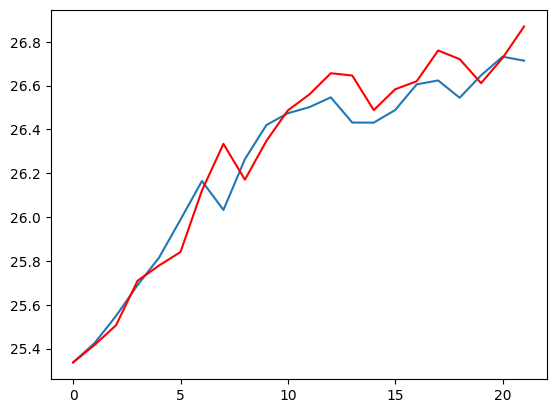

In [81]:
# split into train and test sets
X = yearly_gdp.gdp_log.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX( history,
                        order=(1,0,0), 
                        seasonal_order=(0,1,1,9), 
                        trend='c')
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
ori_test = undo_transforms(test, yearly_gdp.gdp_log[size-1], True, False)
ori_predictions = undo_transforms(predictions, yearly_gdp.gdp_log[size-1], True, False)
rmse = sqrt(mean_squared_error(ori_test, ori_predictions))/1e11
print('Test RMSE: %.3f e11' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Text(0.5, 1.0, 'SARIMA Model Forecast')

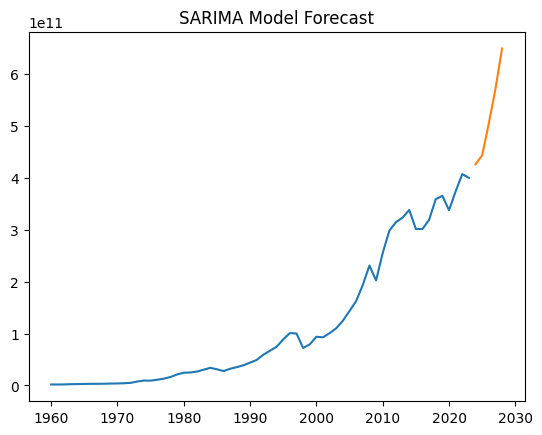

In [82]:
plt.plot(yearly_gdp.gdp)
plt.plot(np.exp(sarima_model.forecast(steps=5)))
plt.title('SARIMA Model Forecast')

In [83]:
# split into train and test sets
X = yearly_gdp.gdp
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

In [84]:
model_1 = ExponentialSmoothing(train, damped_trend=True,
                              trend="multiplicative",
                              seasonal=None,
                              seasonal_periods=None).fit(optimized=True)
preds_1 = model_1.forecast(len(test))
rmse_1 = sqrt(mean_squared_error(test, preds_1))/1e11
print("RMSE for smooth_1: {:.7} e11".format(rmse_1))

RMSE for smooth_1: 0.5204953 e11


c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\priscilla.mukuda\Documents\Learning\Time Series Analysis\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


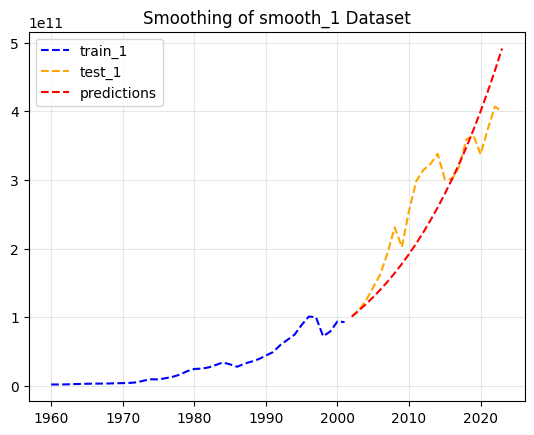

In [85]:
plt.plot(train.index, train, 'b--', label="train_1")
plt.plot(test.index, test, color='orange', linestyle="--", label="test_1")
plt.plot(preds_1.index, preds_1, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Smoothing of smooth_1 Dataset")
plt.grid(alpha=0.3);

plt.show()